In [1]:
!python -m pip install ucimlrepo
!python -m pip install torch
!python -m pip install pykan


[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


NameError: name 'asdSAGDFASGFEHDFHAFDHADF' is not defined

In [124]:
from kan import *
import torch

loss_fn = lambda x, y: torch.mean((x - y) ** 2)
def model_routine(model, dataset):
    model.fit(dataset, opt="LBFGS", steps=10, loss_fn = loss_fn)
    #plot_model(model)
    return model
    
def test_refinment(model, dataset):    
    model = model.refine(10)
    model.fit(dataset, opt="LBFGS", steps=20, loss_fn = loss_fn)
    #plot_model(model)
    return model

In [125]:
def model_refinement(width, dataset):
    pprint = copy.deepcopy(width)
    grids = np.array([3,10,20,35])
    #grids = np.array([50])
    models = []
    train_losses = []
    test_losses = []
    test_loss = []
    train_loss = []
    steps = 200
    k = 3
    for i in range(grids.shape[0]):
        print(grids[i])
        if i == 0:
            model = KAN(width=width, grid=grids[i], k=3, seed=0)
        if i != 0:
            model = model.refine(grids[i])
        results = model.fit(dataset, opt="LBFGS", steps=steps, loss_fn = loss_fn)
        train_loss += results['train_loss']
        test_loss += results['test_loss']
        train_losses.append(results['train_loss'])
        test_losses.append(results['test_loss'])
        models.append(model)

        #plot_model(model)
    plt.title(f"Model with Grid size {grids[i]} and compressionshape {pprint}")
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.legend(['train', 'test'])
    plt.ylabel('RMSE')
    plt.xlabel('step')
    plt.yscale('log')
    path = os.path.join("plots",f"G_{grids[i]}_w_{pprint}_t_{steps}.png"  )
    plt.savefig(path, dpi=300, bbox_inches='tight')
    plt.show()
    return models, train_losses, test_losses

In [126]:
model = KAN(width=[13,3,13], grid=3, k=3, seed = 2)


checkpoint directory created: ./model
saving model version 0.0


In [134]:
def gen_data(num_samples,num_features, width):
    y = np.random.randn(width, num_samples)
    A = np.random.randn(num_features, width)
    data =  np.matmul(A,y).T
    index = int(num_samples * 0.8)
    return {
    'train_input':torch.tensor(data[:index], dtype = torch.float32),
    'test_input':torch.tensor(data[index:], dtype = torch.float32),
    'train_label':torch.tensor(data[:index], dtype = torch.float32),
    'test_label':torch.tensor(data[index:], dtype = torch.float32)
    }



In [128]:
def get_dataset(num_samples,num_features, width, batch_size):
    dataset = gen_data(num_samples,num_features, width)
    train_dataset = torch.utils.data.TensorDataset(dataset['train_input'], dataset['train_label'])
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = torch.utils.data.TensorDataset(dataset['test_input'], dataset['test_label'])
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(dataset['test_input']), shuffle=True)
    return train_dataloader, test_dataloader 


In [129]:
def test_model(model, test_dataloader):
    criterion = nn.MSELoss()
    with torch.no_grad():
        test_loss = 0
        for inputs, targets in test_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        return loss

In [153]:
import torch.optim as optim
import uuid 
def fit(model,dataloader, test_dataloader, epochs=100, lr=0.001):
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 10)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    criterion = lambda x, y: torch.mean((x - y) ** 2)
    #criterion = nn.MSELoss(reduction='mean')
    iteration = 0 # counter on how many consecutive times test_loss below thres
    model.train()
    loss_list = []
    test_loss_list = []
    for epoch in range(epochs):
        total_loss = 0.0
        for inputs, targets in dataloader:
            #print(inputs.shape, targets.shape)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            loss.backward()
            for models in model.enc.layers:
                models.multiply_grad_masks()
            optimizer.step()
            scheduler.step()
        avg_loss = total_loss / len(dataloader)
        loss_list.append(avg_loss)
        test_loss = test_model(model, test_dataloader)
        avg_test_loss = test_loss / len(dataloader)
        test_loss_list.append(test_loss)
        if test_loss < 1e-3:
            iteration += 1
        else:
            iteration = 0
        if iteration == 5:
            break
        print(f"Epoch [{epoch + 1}/{epochs}],Average Loss: {avg_loss:.7f}, Test Loss: {test_loss:.7f}")
    plt.title(f"Model with Grid size {model.shape} and compressionshape {model.h_in}")
    plt.plot(loss_list)
    plt.plot(test_loss_list)
    plt.legend(['train', 'test'])
    plt.ylabel('RMSE')
    plt.xlabel('step')
    plt.yscale('log')
    path = os.path.join("plots",f"neural_kan_{model.shape}_t_{epochs}_{str(uuid.uuid1())[:5]}.png")
    plt.savefig(path, dpi=300, bbox_inches='tight')
    plt.show()

In [137]:
from Kan_NN import Neural_Kan
class compressed_sensor(nn.Module):
    def __init__(self, shape, h_in, out_shape):
        super(compressed_sensor, self).__init__()
        self.shape = shape
        self.h_in = h_in
        self.enc = Neural_Kan(shape = self.shape, h = self.h_in)
        layers = []
        for i in range(len(out_shape) - 1):
            layers.append(nn.Linear(out_shape[i], out_shape[i + 1]))
            layers.append(nn.ReLU())
        layers = layers[:-1] 
        self.dec = nn.Sequential(*layers)
        print(self.dec)
    def forward(self, x):
        encoded = self.enc(x)
        return self.dec(encoded)

In [145]:
batch_size = 32
train_dataset = torch.utils.data.TensorDataset(dataset['train_input'], dataset['train_label'])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = torch.utils.data.TensorDataset(dataset['test_input'], dataset['test_label'])
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(dataset['test_input']), shuffle=True)


100 1
Sequential(
  (0): Linear(in_features=100, out_features=3200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=3200, out_features=6400, bias=True)
  (3): ReLU()
  (4): Linear(in_features=6400, out_features=3200, bias=True)
  (5): ReLU()
)
Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=100, bias=True)
)
Epoch [1/2000],Average Loss: 0.9072059, Test Loss: 1.5509436
Epoch [2/2000],Average Loss: 0.8978899, Test Loss: 1.5468968
Epoch [3/2000],Average Loss: 0.8566925, Test Loss: 1.5461260
Epoch [4/2000],Average Loss: 0.9068195, Test Loss: 1.5460938
Epoch [5/2000],Average Loss: 0.8512756, Test Loss: 1.5457368
Epoch [6/2000],Average Loss: 0.9178588, Test Loss: 1.5447867
Epoch [7/2000],Average Loss: 0.8539079, Test Loss: 1.5414660
Epoch [8/2000],Average Loss: 0.9070963, Test Loss: 1.5356790
Epoch [9/2000],Average Loss: 0.9432126, Test Lo

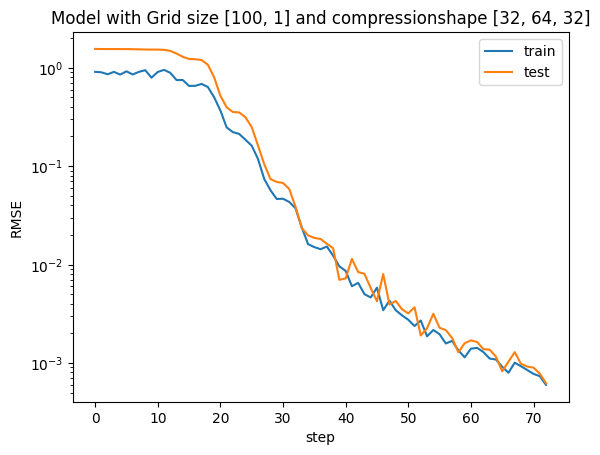

100 2
Sequential(
  (0): Linear(in_features=100, out_features=3200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=3200, out_features=6400, bias=True)
  (3): ReLU()
  (4): Linear(in_features=6400, out_features=3200, bias=True)
  (5): ReLU()
)
Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=100, bias=True)
)
Epoch [1/2000],Average Loss: 1.9012719, Test Loss: 1.8503506
Epoch [2/2000],Average Loss: 1.9479001, Test Loss: 1.8508805
Epoch [3/2000],Average Loss: 2.0084189, Test Loss: 1.8510054
Epoch [4/2000],Average Loss: 1.9269625, Test Loss: 1.8510460
Epoch [5/2000],Average Loss: 1.9117829, Test Loss: 1.8516970
Epoch [6/2000],Average Loss: 2.0540995, Test Loss: 1.8542242
Epoch [7/2000],Average Loss: 2.0361881, Test Loss: 1.8588325
Epoch [8/2000],Average Loss: 2.0160059, Test Loss: 1.8613116
Epoch [9/2000],Average Loss: 2.0820361, Test Lo

In [155]:
epochs = 2000
num_features = 100
for i in range(1,14):
    train_dataloader, test_dataloader = get_dataset(num_samples= num_features,num_features = 100, width = i, batch_size = 32)
    model = compressed_sensor(shape = [num_features,i], h_in = [32,64,32], out_shape = [i,32, 128,num_features])
    fit(model,train_dataloader, test_dataloader, epochs=epochs, lr=0.001)
    #print(torch.max(dataset['test_input'] - model(dataset['test_input']).detach()))
    #print(dataset['test_input'][j] - model(dataset['test_input']).detach()[j])

In [65]:
#for i in range(1,2):
    #model = KAN(width=[13,i,13], grid=3, k=3, seed = 2)
#    model_dict[i] = model_refinement([13,i,13], dataset=dataset)
#import pickle
#with open('model_dict.pkl', 'wb') as f:
#    pickle.dump(model_dict, f)
print(model)

Encoder(
  (encoder): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=13, bias=True)
  )
)


Epoch [1/10], Loss: 0.0162495
Epoch [2/10], Loss: 0.0016088
Epoch [3/10], Loss: 0.0011127
Epoch [4/10], Loss: 0.0009752
Epoch [5/10], Loss: 0.0008565
Epoch [6/10], Loss: 0.0007436
Epoch [7/10], Loss: 0.0006410
Epoch [8/10], Loss: 0.0005812
Epoch [9/10], Loss: 0.0005491
Epoch [10/10], Loss: 0.0005296


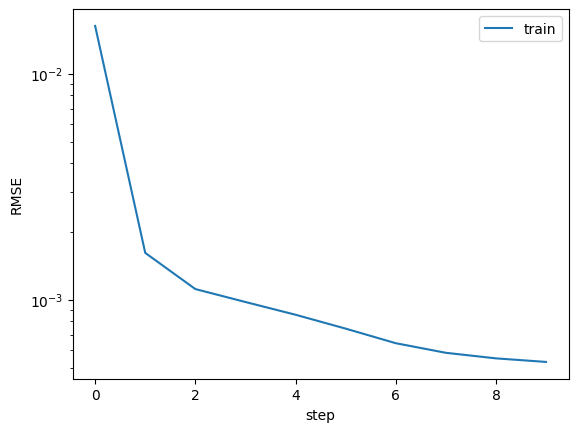

In [64]:
class Encoder(nn.Module):
    def __init__(self, bottleneck_dim):
        super(Encoder, self).__init__()
        self.bottleneck_dim = bottleneck_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(13, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, bottleneck_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 13)
        )

    def forward(self, x):
        bottleneck = self.encoder(x)
        reconstructed = self.decoder(bottleneck)
        return reconstructed

def train(model, train_loader, epochs=20, lr=1e-3, bottleneck_size=5):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    loss_list = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for data,_ in train_loader:
            inputs = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        scheduler.step()
        avg_loss = running_loss / len(train_loader)
        loss_list.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.7f}")
    plt.plot(loss_list)
    plt.legend(['train', 'test'])
    plt.ylabel('RMSE')
    plt.xlabel('step')
    plt.yscale('log')
    plt.show()
    

bottleneck_size = 5
model = Encoder(bottleneck_size)
train(model, train_dataloader, epochs=100, lr=1e-2, bottleneck_size=bottleneck_size)
